# Why matrix inversion doesn't work?
Trying to unfold with a naive matrix inversion approach and with a more educated SVD pseudo-matrix inversion approach

In [1]:
# numpy imports and settings
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=500)
# ROOT imports
import ROOT
import root_numpy
# plotting imports
import pylab as plt
%matplotlib inline

Welcome to JupyROOT 6.23/01


In [25]:
# define a useful util to plot
def plot_everything(Adetpy, xinipy, binipy, xinipy_edges, reconstructed_name=None):
    # Create figure
    fig = plt.figure(figsize=(15, 7))
    # Show response matrix on the left side
    ax = fig.add_subplot(1, 2, 1)
    left_edge  = xinipy_edges[0][0]
    right_edge = xinipy_edges[0][-1]
    bottom_edge  = binipy_edges[0][-1]
    top_edge = binipy_edges[0][0]
    img = ax.imshow(Adetpy, extent=[left_edge, right_edge, bottom_edge, top_edge])
    ax.set_xlabel("true ($x_{ini}$)")
    ax.set_ylabel("measured ($b_{ini}$)")
    ax.set_title("Response matrix (probab. of event from j migrating to i)")
    fig.colorbar(img)
    # Show the histograms on the right side
    ax = fig.add_subplot(1, 2, 2)
    axis = xinipy_edges[0][:-1]
    ax.step(axis, xinipy, fillstyle="bottom", label="$x_{ini}$") # plot x_ini
    ax.fill_between(axis, xinipy, step="pre", alpha=0.4)
    reconstructed_name = "$b_{ini}$" if reconstructed_name is None else reconstructed_name
    ax.step(axis, binipy, fillstyle="bottom", label=reconstructed_name) # plot b_ini
    ax.fill_between(axis, binipy, step="pre", alpha=0.4)
    ax.set_xlabel("x")
    ax.set_ylabel("entries")
    ax.legend()

##  Data preparation

First, create the histogram objects and fill them with MC data

In [3]:
def reconstruct(xt, R):
    cutdummy = -99999.0
    xeff = 0.3 + (1.0 - 0.3) / 20.0 * (xt + 10.0)
    x = R.Rndm()
    if x > xeff:
        return cutdummy
    return xt + R.Gaus(-2.5, 0.2)

# random utils
R = ROOT.TRandom3()
cutdummy = -99999.0

In [4]:
# toy generation
nbins = 5
xini = ROOT.TH1D("xini", "MC truth", nbins, -10, 10)
bini = ROOT.TH1D("bini", "MC reco", nbins, -10, 10)
Adet = ROOT.TH2D("Adet", "detector response", nbins, -10.0, 10.0, nbins, -10.0, 10.0)

# Fill the MC using a Breit-Wigner, mean 0.3 and width 2.5.
amount = 100000
for i in range(amount):
    xt = R.BreitWigner(0.3, 2.5)
    xini.Fill(xt)
    x = reconstruct(xt, R)
    if x != cutdummy:
        Adet.Fill(x, xt)
        bini.Fill(x)

Warning in <TROOT::Append>: Replacing existing TH1: xini (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: bini (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Adet (Potential memory leak).


Turn ROOT objects into python objects and plot

In [26]:
xinipy, xinipy_edges = root_numpy.hist2array(xini, return_edges=True)
binipy, binipy_edges = root_numpy.hist2array(bini, return_edges=True)
Adetpy_events, Adetpy_edges = root_numpy.hist2array(Adet, return_edges=True)
Adetpy = np.true_divide(Adetpy_events, xinipy, where=xinipy!=0)

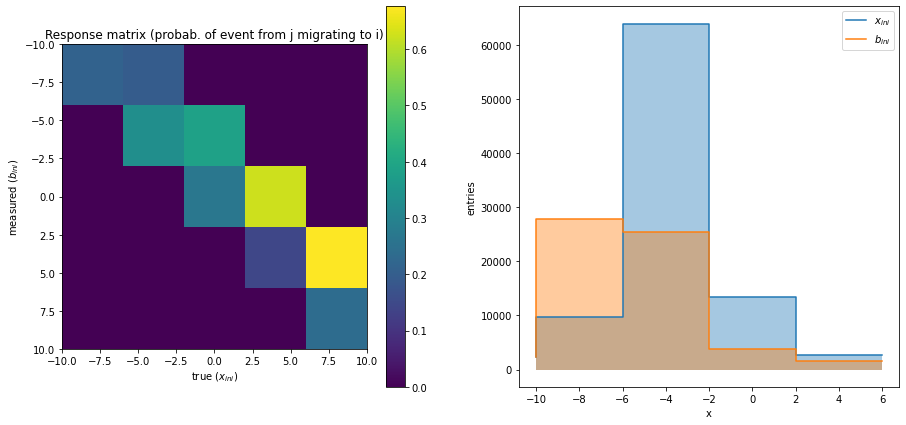

In [27]:
plot_everything(Adetpy, xinipy, binipy, xinipy_edges)

## First try: invert matrix
The resulting histogram will be heavily oscillating due to statistical fluctuations

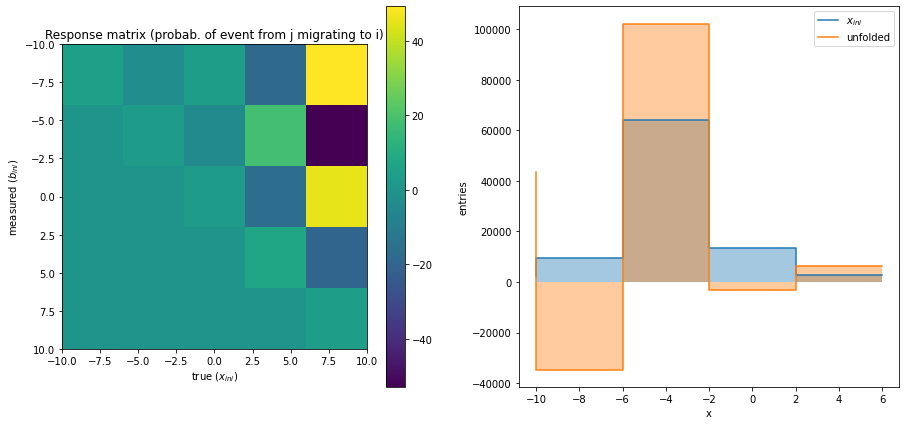

In [44]:
# Invert matrix
Ainv = np.linalg.inv(Adetpy)
# Solve
unfolded = Ainv.dot(binipy)
# Plot
plot_everything(Ainv, xinipy, unfolded, xinipy_edges, reconstructed_name="unfolded")

## Second try: use an SVD inversion
Still not working!

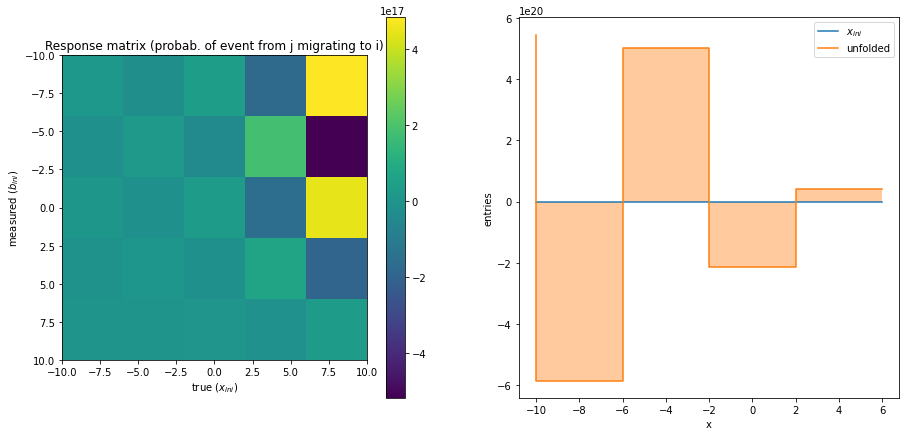

In [81]:
# Pseudo-invert matrix
U, S, Vh = np.linalg.svd(Adetpy, full_matrices=True)
# Truncate (rmax = 5)
r = 4
Apseudo = 0
for i in range(0,r):
    Apseudo += S[i]*np.outer(U[:,i], Vh.T[:,i])
# Invert approximation
Ainv_pseudo = np.linalg.inv(Apseudo)
# Try to unfold
unfolded = Ainv_pseudo.dot(binipy)
# Plot
plot_everything(Ainv_pseudo, xinipy, unfolded, xinipy_edges, reconstructed_name="unfolded")

## Third try: use an SVD inversion but on the inverted matrix!
Still not working!!

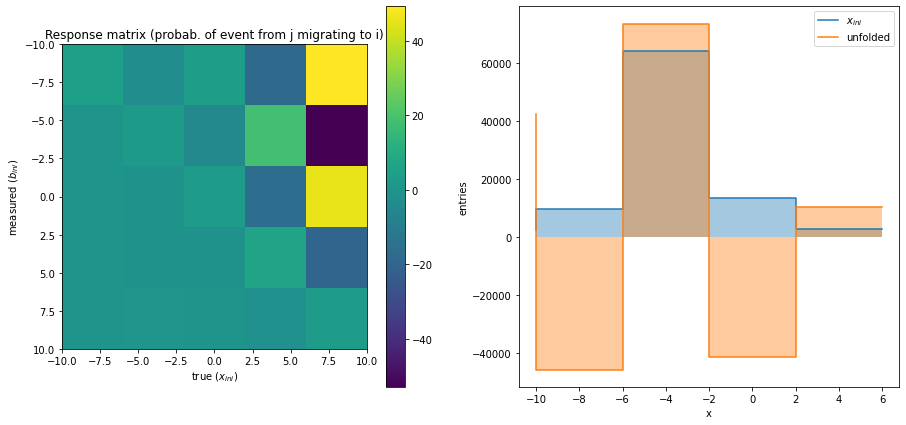

In [88]:
# First invert matrix
Ainv = np.linalg.inv(Adetpy)
# Truncate inversion (rmax = 5)
U, S, Vh = np.linalg.svd(Ainv, full_matrices=True)
r = 3
Ainv_pseudo = 0
for i in range(0,r):
    Ainv_pseudo += S[i]*np.outer(U[:,i], Vh.T[:,i])
# Try to unfold
unfolded = Ainv_pseudo.dot(binipy)
# Plot
plot_everything(Ainv_pseudo, xinipy, unfolded, xinipy_edges, reconstructed_name="unfolded")